In [2]:
import os
import numpy as np
import pandas as pd
import pycatch22
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

Data loaded from /Volumes/SinhaData/hup_clean/sub-RID0031/sub-RID0031_features_averaged.pkl with shape: (81, 49)
After dropping missing values, data shape is: (81, 43)
Cross-validation results:
  Average Accuracy: 0.913 ± 0.050
  Average ROC AUC: 0.964 ± 0.024

Classification Report on Full Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        12

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



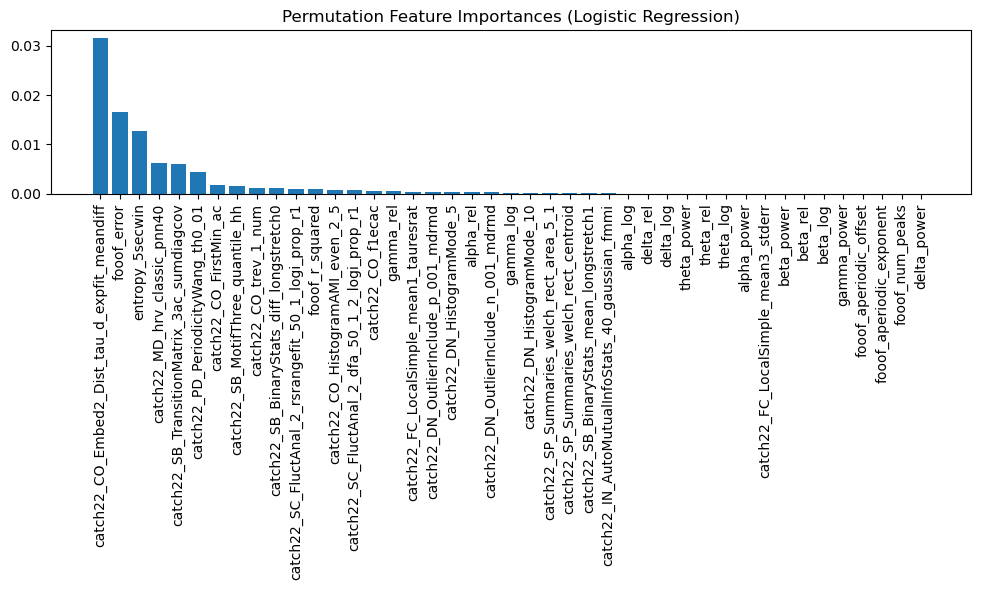


Feature Selection Results:
Optimal number of features: 6

Selected features:
- fooof_error
- entropy_5secwin
- catch22_CO_FirstMin_ac
- catch22_MD_hrv_classic_pnn40
- catch22_PD_PeriodicityWang_th0_01
- catch22_CO_Embed2_Dist_tau_d_expfit_meandiff


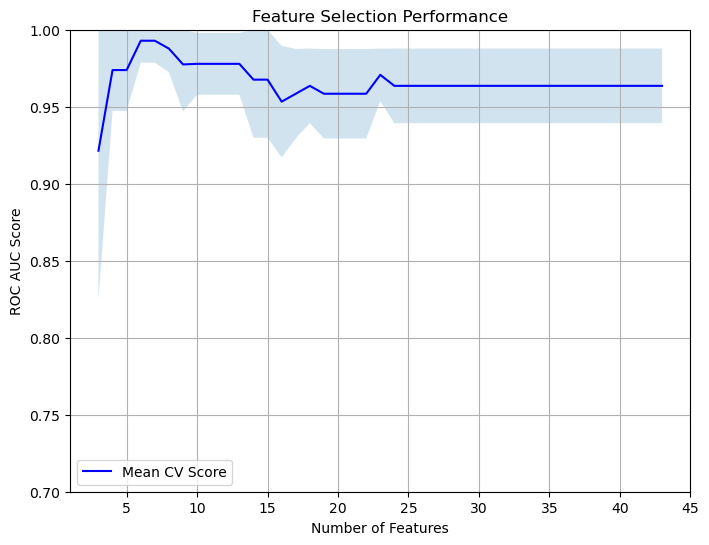

In [9]:
# Channel Classification and Feature Importance Pipeline

# Define an explicit feature list
def get_feature_list():
    # Bandpower features for each band
    band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    band_features = [f"{band}_{metric}" for band in band_names for metric in ['power', 'rel', 'log']]
    # FOOOF features
    fooof_features = [
        'fooof_aperiodic_offset',
        'fooof_aperiodic_exponent',
        'fooof_r_squared',
        'fooof_error',
        'fooof_num_peaks'
    ]
    # Entropy feature
    entropy_features = ['entropy_5secwin']
    # Catch22 features (obtained via a dummy call)
    dummy = np.random.randn(100).tolist()
    res = pycatch22.catch22_all(dummy, catch24=False)
    catch22_features = [f"catch22_{nm}" for nm in res['names']]
    return band_features + fooof_features + entropy_features + catch22_features

# Function to convert the 'spared' column to a binary label: 0 for spared, 1 for resected
def convert_spared_to_label(val):
    if isinstance(val, bool):
        return 0 if val else 1
    elif isinstance(val, str):
        return 0 if val.strip().upper() == 'TRUE' else 1
    else:
        return 0 if bool(val) else 1

# ---------------- Data Loading and Preprocessing ----------------

# Set the path to the aggregated data for subject sub-RID0031
data_path = "/Volumes/SinhaData/hup_clean/sub-RID0031/sub-RID0031_features_averaged.pkl"
df = pd.read_pickle(data_path)
print(f"Data loaded from {data_path} with shape: {df.shape}")

# Get the explicit feature list and check which features are present
feature_list = get_feature_list()
present_features = [feat for feat in feature_list if feat in df.columns]
missing_features = set(feature_list) - set(present_features)
if missing_features:
    print("Warning: The following expected features are missing:")
    print(missing_features)

# Convert the 'spared' column into a binary label (0: spared, 1: resected)
if 'spared' not in df.columns:
    raise ValueError("Column 'spared' not found in the data.")
df['label'] = df['spared'].apply(convert_spared_to_label)

# Drop rows with missing values in the predictor features
df_clean = df.dropna(subset=present_features)
X = df_clean[present_features].copy()
y = df_clean['label'].values
print(f"After dropping missing values, data shape is: {X.shape}")

# Standardize predictors via z-scoring
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------- Model Training and Evaluation ----------------
# Choose classifier: set model_choice to "logistic" or "random_forest"
model_choice = "logistic"


if model_choice == "logistic":
    clf = LogisticRegression(max_iter=1000, random_state=42)
elif model_choice == "random_forest":
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
else:
    raise ValueError("Model choice must be 'logistic' or 'random_forest'.")

# Perform stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies, aucs = [], []
for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
        aucs.append(roc_auc_score(y_test, y_proba))
    accuracies.append(accuracy_score(y_test, y_pred))

print("Cross-validation results:")
print(f"  Average Accuracy: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}")
if aucs:
    print(f"  Average ROC AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

# Train the final model on the full dataset and output the classification report
clf.fit(X_scaled, y)
y_pred_all = clf.predict(X_scaled)
print("\nClassification Report on Full Data:")
print(classification_report(y, y_pred_all))

# ---------------- Feature Importance Assessment ----------------

if model_choice == "random_forest":
    # For Random Forest, use built-in feature importances
    importances = clf.feature_importances_
    feature_names = np.array(present_features)
    sorted_idx = np.argsort(importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_idx], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
    plt.title('Random Forest Feature Importances')
    plt.tight_layout()
    plt.show()

    # Perform cross validation with increasing number of top features
    n_features_range = range(1, len(feature_names) + 1)
    mean_scores = []
    std_scores = []
    
    for n_features in n_features_range:
        # Get top n features based on importance
        selected_features = feature_names[sorted_idx][:n_features]
        # Calculate cross validation scores using selected features
        scores = cross_val_score(
            clf, 
            X[selected_features], 
            y, 
            cv=5, 
            scoring='roc_auc'
        )
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    # Plot feature selection performance
    plt.figure(figsize=(8, 6))
    plt.plot(n_features_range, mean_scores, 'b-', label='Mean CV Score')
    
    # Ensure error bands don't exceed 1.0
    lower_bound = np.maximum(0, np.array(mean_scores) - np.array(std_scores))
    upper_bound = np.minimum(1, np.array(mean_scores) + np.array(std_scores))
    
    plt.fill_between(
        n_features_range,
        lower_bound,
        upper_bound,
        alpha=0.2
    )
    plt.xlabel("Number of Features")
    plt.ylabel("ROC AUC Score")
    plt.title("Feature Selection Performance")
    plt.legend()
    plt.grid(True)
    plt.ylim(0.7, 1)
    plt.show()

    # Print optimal number of features
    optimal_n_features = n_features_range[np.argmax(mean_scores)]
    print("\nFeature Selection Results:")
    print(f"Optimal number of features: {optimal_n_features}")
    print("\nTop features:")
    for feature in feature_names[sorted_idx][:optimal_n_features]:
        print(f"- {feature}")

    

elif model_choice == "logistic":
    # Plotting Feature Importances
    result = permutation_importance(clf, X_scaled, y, n_repeats=30, random_state=42, scoring='roc_auc')
    importances = result.importances_mean
    feature_names = np.array(present_features)
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_idx], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=90)
    plt.title('Permutation Feature Importances (Logistic Regression)')
    plt.tight_layout()
    plt.show()
    
    # For Logistic Regression, use cross-validated RFE
    rfecv = RFECV(estimator=clf, step=1, cv=skf, scoring='roc_auc', min_features_to_select=3)
    rfecv.fit(X_scaled, y)
    
    # Print selected features and their importance
    selected_features = feature_names[rfecv.support_]
    print("\nFeature Selection Results:")
    print(f"Optimal number of features: {rfecv.n_features_}")
    print("\nSelected features:")
    for feature in selected_features:
        print(f"- {feature}")
    
    # Plot feature selection scores
    cv_results = pd.DataFrame(rfecv.cv_results_)
    plt.figure(figsize=(8, 6))
    plt.plot(cv_results["n_features"], cv_results["mean_test_score"], 'b-', label='Mean CV Score')
    
    # Ensure error bands don't exceed 1.0
    lower_bound = np.maximum(0, cv_results["mean_test_score"] - cv_results["std_test_score"])
    upper_bound = np.minimum(1, cv_results["mean_test_score"] + cv_results["std_test_score"])
    
    plt.fill_between(
        cv_results["n_features"],
        lower_bound,
        upper_bound,
        alpha=0.2
    )
    plt.xlabel("Number of Features")
    plt.ylabel("ROC AUC Score")
    plt.title("Feature Selection Performance")
    plt.legend()
    plt.grid(True)
    plt.ylim(0.7, 1)  
    plt.show()



